# Estimating Recovered Rate from Serology tests with unknown test charactaristics

**DISCLAIMER: Work in progress. Results unverified.**

> Corey Chivers <corey.chivers@pennmedicine.upenn.edu>

### Goal:
Estimate the proportion $\theta$ of recovered individuals in a population from a serological survey

### Challenge:
The test charactaristics (sensitivity & specificity) are unknown.

### Approach:
Use a Bayesian approach and evaluate the effect of prior probability assumptions over sensitivity, sensitivity, and $\theta$ on our estimate $\hat{\theta}$.


Under a perfect testing regime ($sens=spec=1.0$), we can directly compute the posterior distribution of $\theta$ given observasions D as:

$$P(\theta \vert D) \sim \beta(D^{+} + 1, D^{-} + 1)$$

Where $D^{+}$ is the number of test-positive cases, and $D^{-}$ is the number of test-negative cases, assuming a uniform prior on $\theta$. Non-uniform priors can be incorporated by adding to the two $\beta$ distribution parameters proportional to the disired strength of the prior.

For an imperfect test, we know that only a fraction of the observed test-positives $D_{o}^{+}$ (subscripted $o$) are actual positives  $D_{a}^{+}$ (subscripted $a$). Similarly for negatives. Since:
$$Sens = \frac{TP}{P}$$
and
$$Spec = \frac{TN}{N}$$
We can write $D_{a}^{*}$ in terms of the observed and the charactaristic:
$$D_{a}^{+} = D_{o}^{+} \times Sens  + D_{o}^{-} \times (1 - Spec)$$
and 
$$D_{a}^{-} = D_{o}^{-} \times Spec + D_{o}^{+} \times (1 - Sens)$$

Such that we can write the full model as:
$$P(\theta \vert D_{a}, a_{\theta}, b_{\theta}) \sim \beta(D_{a}^{+} + a_{\theta}, D_{a}^{-} + b_{\theta})$$

With priors:

$$P(Sens) \sim \beta(a_{Sens}, b_{Sens})$$
.
$$P(Spec) \sim \beta(a_{Spec}, b_{Spec})$$
.
$$P(\theta) \sim \beta(a_{\theta}, b_{\theta})$$

From this model, we need only place priors (can be uninformative, or 'flat') on test sensitivity, specificity, and $\theta$ via hyperparameters $a_{Sens}, b_{Sens}, a_{Spec}, b_{Spec}, a_{\theta}$, and $b_{\theta}$ in order to estimate the posterior distribution of $\theta$ given the observed test data.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from scipy.stats import beta
from scipy.optimize import fmin

import numpy as np

import ipywidgets as widgets

In [3]:
def beta_from_q(l, u, quantiles_percent=0.95):
    def loss(params):
        a, b = params
        lq = (1 - quantiles_percent) / 2
        uq = 1 - lq
        return ( (beta.cdf(l, a, b) - lq)**2 + (beta.cdf(u, a, b) - uq)**2 )

    start_params = (1, 1)
    fit = fmin(loss, start_params, disp=0)
    return fit

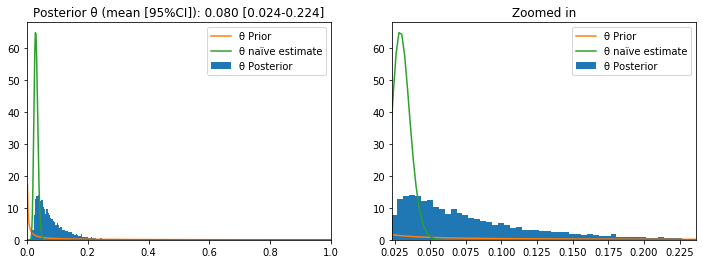

In [4]:
def print_estimate(p_theta):
    mean_p = p_theta.mean()
    ci = np.percentile(p_theta, q=[2.5, 97.5])
    return f"Posterior θ (mean [95%CI]): {mean_p:.3f} [{ci[0]:.3f}-{ci[1]:.3f}]"

    
def theta_unknown_test(d_o_plus, d_o_neg, sens_bounds, spec_bounds, theta_bounds):
    """Draw samples from posterior distribution of θ under
    prior assumptions on test charactaristics."""

    boot_n = 10000
    sens_prior = beta_from_q(sens_bounds[0], sens_bounds[1])
    spec_prior = beta_from_q(spec_bounds[0], spec_bounds[1])
    theta_prior = beta_from_q(theta_bounds[0], theta_bounds[1])

    sens = beta.rvs(sens_prior[0], sens_prior[1], size=boot_n)
    spec = beta.rvs(spec_prior[0], spec_prior[1], size=boot_n)

    d_a_plus = d_o_plus * sens + d_o_neg * (1-spec)
    d_a_neg = d_o_neg * spec + d_o_plus * (1-sens)

    p_theta = beta.rvs(d_a_plus + theta_prior[0], d_a_neg + theta_prior[1])

    fig, axx = plt.subplots(1,2, figsize=(12,4))

    #x_dens = np.linspace(p_theta.min(), p_theta.max())
    x_dens = np.linspace(0,1,500)
    y_dens_theta = beta.pdf(x_dens, theta_prior[0], theta_prior[1])
    y_dens_naive= beta.pdf(x_dens, d_o_plus + 1, d_o_neg + 1)

    ax = axx[0]
    ax.hist(p_theta, bins=100, density=True, label="θ Posterior");
    ax.plot(x_dens, y_dens_theta, label='θ Prior');
    ax.plot(x_dens, y_dens_naive, label='θ naïve estimate');
    ax.set_xlim(0,1)
    ax.legend(loc=0)
    ax.set_title(print_estimate(p_theta))
    
    ax = axx[1]
    ax.hist(p_theta, bins=100, density=True, label="θ Posterior");
    ax.plot(x_dens, y_dens_theta, label='θ Prior');
    ax.plot(x_dens, y_dens_naive, label='θ naïve estimate');
    lims = np.percentile(p_theta, q=[2, 98])
    ax.set_xlim(lims[0],lims[1])
    ax.legend(loc=0)
    ax.set_title('Zoomed in')
    
    plt.show()
    
    
theta_unknown_test(22, 739, sens_bounds=[0.8,0.999], spec_bounds=[0.8,0.999], theta_bounds=[0.0,0.3])

### Interactive Version

In [5]:
@widgets.interact(d_o_plus=widgets.IntText(
              min=0, max=1000, step=1, value=22, description='Positive Tests'),
          d_o_neg=widgets.IntText(
              min=0, max=1000, step=1, value=761-22, description='Negative Tests'), 
          sens_bounds=widgets.FloatRangeSlider(
              min=0.0, max=1.0, step=0.01, value=[0.5, 0.975], description="Sensitivity"),
          spec_bounds=widgets.FloatRangeSlider(
              min=0.0, max=1.0, step=0.01, value=[0.5, 0.975], description="Specificity"),
          theta_bounds=widgets.FloatRangeSlider(
              min=0.001, max=0.99, step=0.01, value=[0.0, 0.5], description="θ Prior"))
def interactive_theta_unknown_test(d_o_plus, d_o_neg, sens_bounds, spec_bounds, theta_bounds):
    theta_unknown_test(d_o_plus, d_o_neg, sens_bounds, spec_bounds, theta_bounds)

interactive(children=(IntText(value=22, description='Positive Tests'), IntText(value=739, description='Negativ…